Horse: 86 imágenes


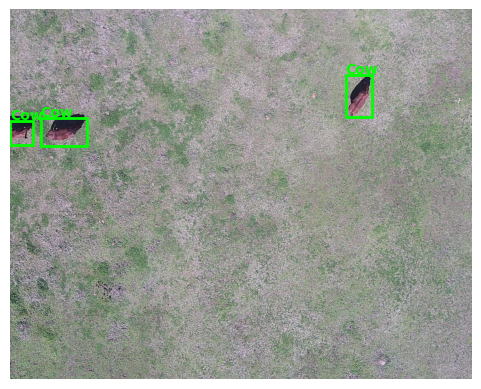

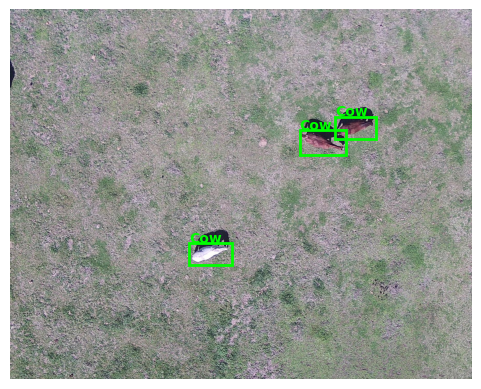

Deer: 106 imágenes


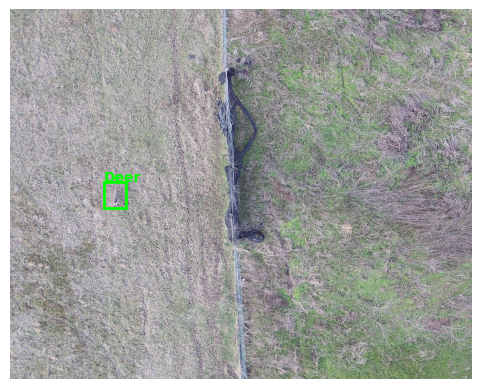

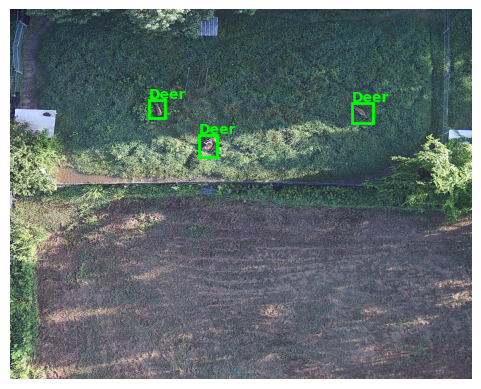

Cow: 136 imágenes


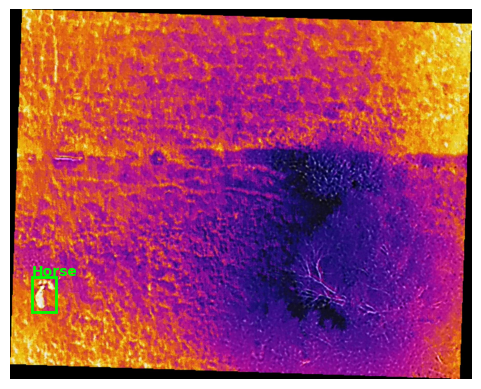

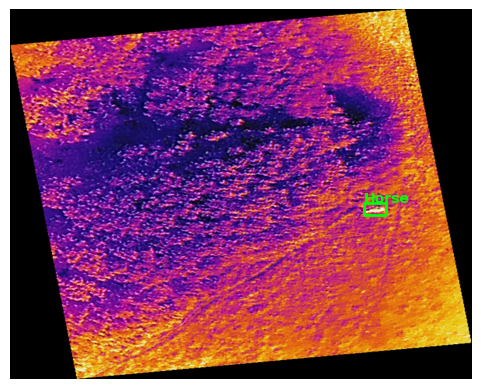

In [1]:
from utils_IT import *
images = load_images_by_class('data', ['Horse', 'Deer', 'Cow'])